In [1]:
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
from tqdm.notebook import tqdm
import os
import pandas as pd

In [2]:
# !nvidia-smi

In [3]:
# device = torch.device(
#     "mps") if torch.backends.mps.is_available() else torch.device("cpu")

device = "cpu"

In [4]:
BATCH_SIZE = 16
SELECTED_MODEL = "Salesforce/blip2-opt-2.7b-coco"
IMAGE_FOLDER_PATH = "../../dataset/coco/test2017"

In [5]:
images = []

for it in tqdm(os.listdir(IMAGE_FOLDER_PATH)):
    images.append(f"{IMAGE_FOLDER_PATH}/{it}")

  0%|          | 0/40670 [00:00<?, ?it/s]

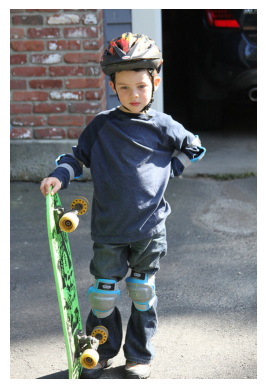

In [6]:
import matplotlib.pyplot as plt

img = Image.open(images[0])
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
processor = Blip2Processor.from_pretrained(SELECTED_MODEL)
model = Blip2ForConditionalGeneration.from_pretrained(
    SELECTED_MODEL, torch_dtype=torch.float16).to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
def make_batches(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [9]:
if not os.path.exists('temp'):
    os.makedirs('temp')

In [10]:
submissions = []

for idx, batch in enumerate(tqdm(make_batches(images, BATCH_SIZE), desc="Processing images", total=len(images)//BATCH_SIZE+1)):

    cur_idx_list = images[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]

    images_batch = [Image.open(img)
                    for img in tqdm(cur_idx_list, desc="To PIL")]

    pixel_values = processor(images=images_batch, text=[
                             "this is an image of"] * len(images_batch), return_tensors="pt")
    out = model.generate(**pixel_values, max_new_tokens=256)
    prompts = processor.batch_decode(out, skip_special_tokens=True)

    for appidx, image_path in tqdm(enumerate(cur_idx_list), desc="To List"):
        submissions.append({"image_id": "/".join(image_path.replace(".jpg",
                           "").split("/")[-2:]), "caption": prompts[appidx]})

    pd.DataFrame(submissions[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
                 ).to_csv(f"/kaggle/working/temp/batch{idx}.csv", index=False)

    break

Processing images:   0%|          | 0/2542 [00:00<?, ?it/s]

To PIL:   0%|          | 0/16 [00:00<?, ?it/s]

Both `max_new_tokens` (=256) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


To List: 0it [00:00, ?it/s]

OSError: Cannot save file into a non-existent directory: '/kaggle/working/temp'

In [12]:
text_pred_df = pd.DataFrame(submissions)

text_pred_df

,image_id,caption
0,test2017/000000339995,a young boy holding a skateboard\n
1,test2017/000000088328,a cat sitting on top of a laptop\n
2,test2017/000000426344,a group of people on skis\n
3,test2017/000000265032,a group of people boarding a plane\n
4,test2017/000000223067,a person holding a fork and a slice of pizza\n
5,test2017/000000532443,a baseball player sliding into a base\n
6,test2017/000000184260,a baby zebra standing next to an adult zebra\n
7,test2017/000000562274,a person on skis on a snow covered slope\n
8,test2017/000000469453,two women holding up two pizzas\n
9,test2017/000000014667,two men sitting on a bench\n


In [13]:
text_pred_df.to_csv("./temp/processed.csv", index=False)